## 연합뉴스 타이틀 주제 분류
* 데이터셋 출처 : 
    * [뉴스 토픽 분류 AI 경진대회 - DACON](https://dacon.io/competitions/official/235747/overview/description)

## 기초 분류 모델 만들기

* 데이터 로드
* 데이터 전처리
* 단어 벡터화(BOW, TF-IDF)
* 분류기 설정하기
* 분류기로 학습시키기
* 학습의 정확도 보기
* 테스트 데이터 예측하기
* 실제 데이터와 예측결과의 차이를 보기

<img src="https://i.imgur.com/Sxm12BY.png" width="900">



## 라이브러리 로드

In [1]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy, 시각화를 위한 seaborn, matplotlib 을 로드합니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 시각화를 위한 폰트 설정

In [2]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family


# style 설정은 꼭 폰트설정 위에서 합니다.
# style 에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 한글이 깨집니다.
plt.style.use("seaborn")
# 폰트설정
plt.rc("font", family=get_font_family())

# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

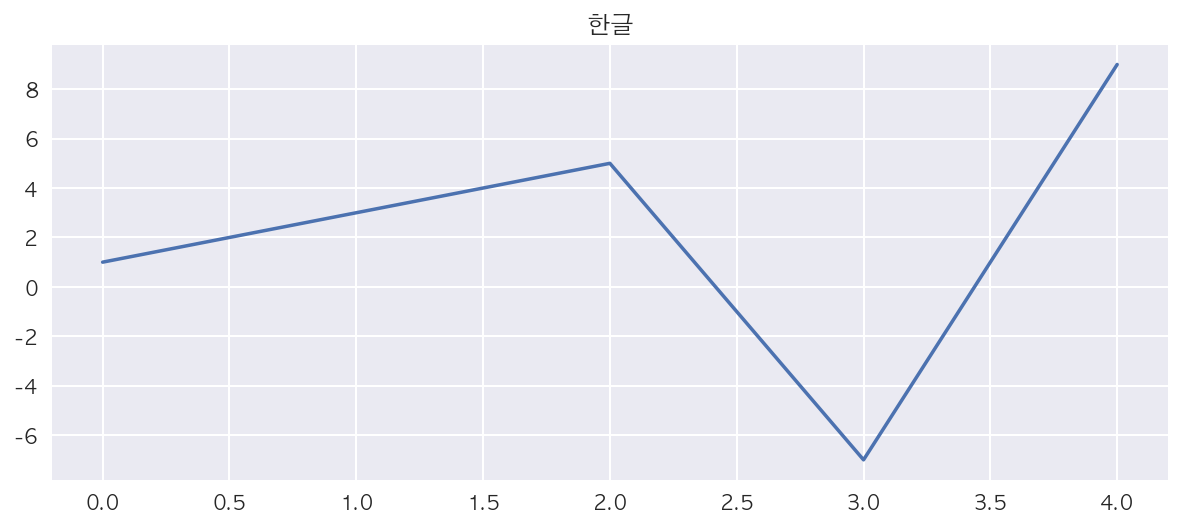

In [3]:
pd.Series([1, 3, 5, -7, 9]).plot(title="한글", figsize=(10, 4))

## 데이터 로드

In [4]:
# 학습, 예측 데이터셋을 불러옵니다.
train = pd.read_csv("data/klue/train_data.csv")
test = pd.read_csv("data/klue/test_data.csv")
train.shape, test.shape

((45654, 3), (9131, 2))

In [5]:
# 토픽을 불러옵니다.
topic = pd.read_csv("data/klue/topic_dict.csv")
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


## 전처리를 위한 데이터 병합
* 학습, 예측 세트를 똑같이 전처리 해주기 위해 각각 같은 방법을 적용해 줄 수도 있지만
* 두 데이터를 병합해서 전처리를 해주고 다시 나눠주겠습니다.

## concat
<img src="https://pandas.pydata.org/docs/_images/08_concat_row.svg" width="500">

In [6]:
# 전처리를 위해 데이터 병합
df = pd.concat([train, test], axis=0)
train.shape, test.shape, df.shape

((45654, 3), (9131, 2), (54785, 3))

## 정답값 빈도수
* train 에서 제공하는 정답값의 빈도수

In [7]:
topic["topic"]

0    IT과학
1      경제
2      사회
3    생활문화
4      세계
5     스포츠
6      정치
Name: topic, dtype: object

In [8]:
# 정답값 빈도수를 확인합니다.
topic_count = df["topic_idx"].value_counts().sort_index()
topic_count.index = topic["topic"]
topic_count

topic
IT과학    4824
경제      6222
사회      7362
생활문화    5933
세계      7629
스포츠     6933
정치      6751
Name: topic_idx, dtype: int64

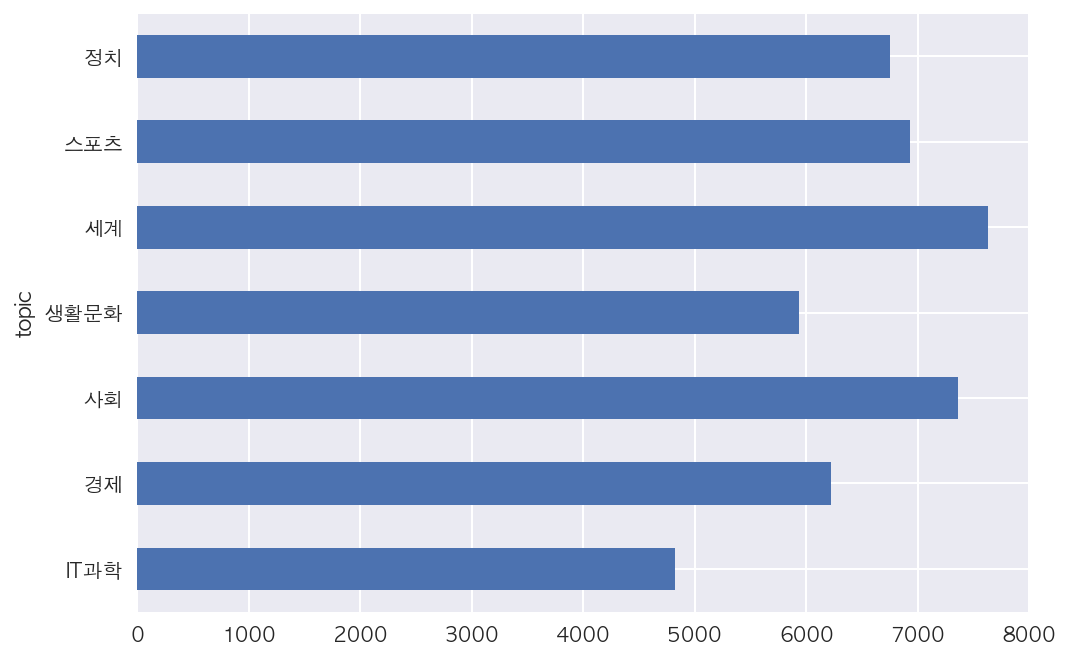

In [9]:
# 정답값 빈도수를 시각화 합니다.
topic_count.plot.barh()

## 문자 전처리

In [10]:
# 정규표현식
import re

def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    #text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    # 중복으로 생성된 공백값을 제거합니다.
    text = re.sub('[\s]+', ' ', text)
    # 영문자를 소문자로 만듭니다.
    text = text.lower()
    return text

In [11]:
# map을 통해 전처리 일괄 적용
df["title"] = df["title"].map(preprocessing)
df["title"].head()

0            인천 핀란드 항공기 결항 휴가철 여행객 분통
1         실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화
2      이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3    nyt 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4           시진핑 트럼프에 중미 무역협상 조속 타결 희망
Name: title, dtype: object

### 불용어 제거

In [12]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = [ '합니다', '하는', '할', '하고', '한다', 
             '그리고', '입니다', '그', '등', '이런', '및','제', '더']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [13]:
df["title"] = df["title"].map(remove_stopwords)
df["title"].head()

0            인천 핀란드 항공기 결항 휴가철 여행객 분통
1         실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화
2      이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3    nyt 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4           시진핑 트럼프에 중미 무역협상 조속 타결 희망
Name: title, dtype: object

## 학습, 예측 데이터셋 분리
* 전처리가 되었다면 concat 으로 합쳐주었던 데이터프레임을 다시 학습과 예측 데이터셋으로 분리합니다.

In [14]:
# 정답값으로 사용할 topic_idx 를 변수에 담아 재사용 합니다.
label_name = "topic_idx"
label_name

'topic_idx'

In [15]:
# label_name 을 기준으로 학습, 예측 세트를 분리합니다.
# label_name 이 있다면 학습 세트, 없다면 예측 세트가 됩니다.
# df_train
# df_test
df_train = df[df["topic_idx"].notnull()].copy()
df_test = df[df["topic_idx"].isnull()].copy()
df_train.shape, df_test.shape

((45654, 3), (9131, 3))

In [22]:
# 학습, 예측에 사용할 문제를 나눕니다.
# 기출문제(X_train)과 실전문제(X_test)를 나눈다고 볼 수 있습니다.
# X_train_text
# X_test_text
X_train_text = df_train["title"]
X_test_text = df_test["title"]
X_train_text.shape, X_test_text.shape

((45654,), (9131,))

In [23]:
# 기출문제의 정답을 만들어 줍니다.
# 잘 나뉘었는지 정닶 값의 빈도수를 확인해 봅니다.
y_train = df_train[label_name]
y_train.shape

(45654,)

In [24]:
# 테스트의 정답은 모두 결측치 입니다.
# Dacon 사이트에 예측 값을 제출해야 맞고 틀린 갯수를 알 수 있습니다.
y_test =  df_test[label_name]
y_test.shape

(9131,)

## 벡터화
* 머신러닝이나 딥러닝 알고리즘은 문자를 이해할 수 없습니다. 내부에서는 수치 계산이 이루어지기 때문에 문자를 숫자로 변경해 주어야 합니다.


### TF-IDF(Term Frequency - Inverse Document Frequency)

정보 검색과 텍스트 마이닝에서 이용하는 가중치로, 여러 문서로 이루어진 문서군이 있을 때 어떤 단어가 특정 문서 내에서 얼마나 중요한 것인지를 나타내는 통계적 수치이다. 문서의 핵심어를 추출하거나, 검색 엔진에서 검색 결과의 순위를 결정하거나, 문서들 사이의 비슷한 정도를 구하는 등의 용도로 사용할 수 있다.

TF(단어 빈도, term frequency)는 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값으로, 이 값이 높을수록 문서에서 중요하다고 생각할 수 있다. 하지만 단어 자체가 문서군 내에서 자주 사용 되는 경우, 이것은 그 단어가 흔하게 등장한다는 것을 의미한다. 이것을 DF(문서 빈도, document frequency)라고 하며, 이 값의 역수를 IDF(역문서 빈도, inverse document frequency)라고 한다. TF-IDF는 TF와 IDF를 곱한 값이다.

IDF 값은 문서군의 성격에 따라 결정된다. 예를 들어 '원자'라는 낱말은 일반적인 문서들 사이에서는 잘 나오지 않기 때문에 IDF 값이 높아지고 문서의 핵심어가 될 수 있지만, 원자에 대한 문서를 모아놓은 문서군의 경우 이 낱말은 상투어가 되어 각 문서들을 세분화하여 구분할 수 있는 다른 낱말들이 높은 가중치를 얻게 된다.

\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \times (\log\big(\frac{N + 1}{N_w + 1}\big) + 1)
\end{equation*}


* 출처 : [tf-idf - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/Tf-idf)

In [25]:
# TfidfVectorizer 로 벡터화 합니다.
# fit 으로 변환할 어휘를 학습합니다.
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvect = TfidfVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=2)
tfidfvect.fit(X_train_text)

TfidfVectorizer(min_df=2)

In [29]:
# transform
# X_train
# X_test
X_train = tfidfvect.transform(X_train_text)
X_test = tfidfvect.transform(X_test_text)
X_train.shape, X_test.shape

((45654, 27314), (9131, 27314))

In [30]:
# 단어 사전 feature_names
# tfidfvect.vocabulary_
feature_names = tfidfvect.get_feature_names_out()
len(feature_names)

27314

In [34]:
# np.sum 으로 위에서 구한 TF-IDF 값을 단어별로 더합니다. axis=0 으로 합니다. 
df_vocab = pd.DataFrame(X_train.toarray(), columns=feature_names)
df_vocab = df_vocab.sum().to_frame()
df_vocab

,0
aa,1.062553
aa로,0.984721
abs,1.592133
ab운용,0.972684
ac,1.432793
...,...
힘을,0.870914
힘이,1.555737
힘입어,2.042702
힘찬,2.533876


In [35]:
# TF-IDF 합계 값이 높은 상위 10개 어휘
df_vocab_top = df_vocab[0].nlargest(50)
df_vocab_top

대통령    347.042849
신간     258.192677
억원     248.103273
게시판    229.108308
출시     207.983761
분기     177.066217
kt     167.871350
이란     164.742991
감독     163.620994
개최     153.081852
트럼프    151.850445
한국     150.744945
개발     135.781708
만에     131.233117
그래픽    128.016230
작년     125.376293
경기     121.351764
올해     120.462835
정부     119.870465
코로나    118.110907
삼성     113.260259
김정은    112.545961
월드컵    112.293390
공개     111.974698
서울     110.655308
lg     110.154821
코스피    107.390881
영업익    103.758699
개막     102.215817
시즌     101.537165
류현진    100.090209
최대     100.037840
지원     100.016714
중국      98.980714
연속      97.933260
네이버     97.908155
국내      97.519997
연승      96.718616
사망      92.495336
미국      91.204134
서비스     91.191077
추진      90.170632
증가      89.514664
내년      89.382372
skt     88.141987
전국      87.396746
세계      86.931613
꺾고      85.979718
최고      85.377464
터키      83.974892
Name: 0, dtype: float64

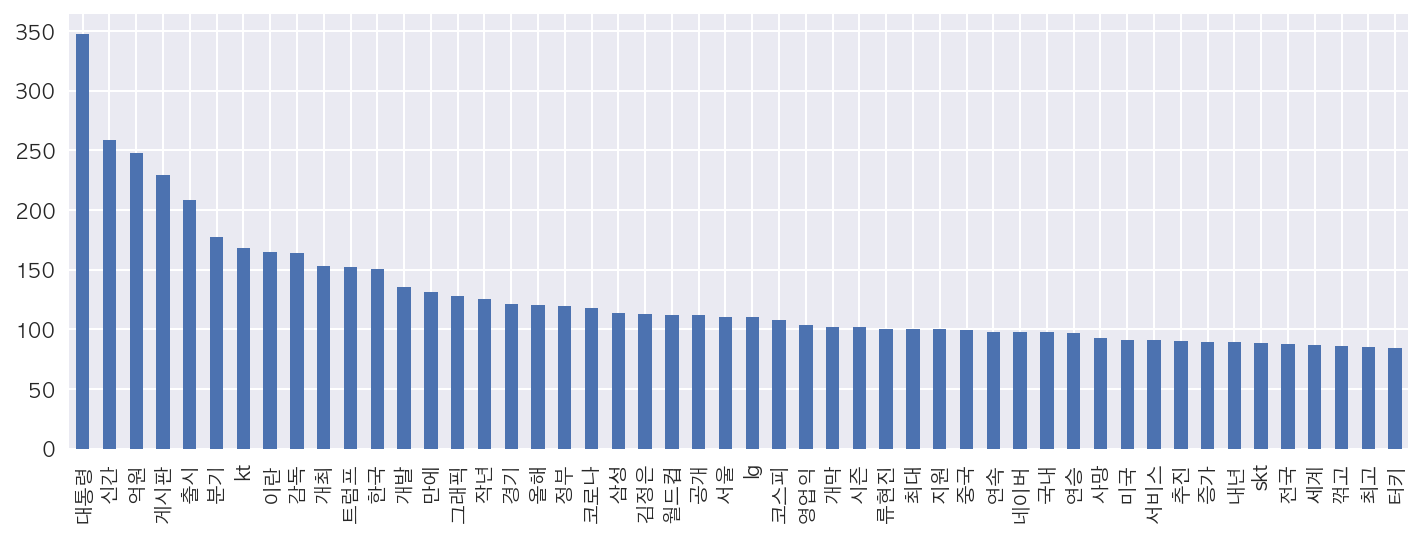

In [33]:
# 위에서 구한 빈도수를 그래프로 그립니다.
df_vocab_top.plot.bar(figsize=(12, 4))

## 모델

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Randomforests_ensemble.gif">


### Randomforest Parameter
* n_estimators	
    * 결정트리의 개수, 많을 수록 성능이 좋아지나 오래걸리며 샘플의 수에 따라 트리를 만들 수 있는 개수가 제한적
* max_depth
    * 트리의 최대 깊이
* max_features	
    * 피처의 개수(int) 혹은 비율(float)
    * sqrt 또는 auto : 전체 피처 중 √(피처개수) 만큼 사용
    * log : 전체 피처 중 log2(전체 피처 개수) 만큼 
* min_samples_split
    * 노드를 분할하기 위한 최소 샘플 데이터수
* min_samples_leaf
    * 리프노드가 되기 위해 필요한 최소 샘플 데이터수
* max_leaf_nodes
    * 리프노드의 최대 개수
* n_jobs
    * 사용할 CPU 코어의 수, -1로 설정 시 사용할 수 있는 모든 CPU코어를 사용

전체 과정
* feature_names : 학습(훈련), 예측에 사용할 단어 사전 입니다.
* label_name : 정답값

* X_train : 학습(훈련)에 사용할 데이터셋 예) 시험의 기출문제

* X_test : 예측에 사용할 데이터셋 예) 실전 시험문제

* y_train : label_name 에 해당 되는 컬럼만 train에서 가져옵니다.
    * 학습(훈련)에 사용할 정답 값 예) 기출문제의 정답

* model : 학습, 예측에 사용할 머신러닝 알고리즘

* model.fit(X_train, y_train) : 학습(훈련), 기출문제와 정답을 가지고 학습(훈련)하는 과정과 유사합니다.

* model.predict(X_test) :  예측, 실제 시험을 보는 과정과 유사합니다. => 문제를 풀어서 정답을 구합니다.

* score
    * 시험을 봤다면 몇 문제를 맞고 틀렸는지 채점해 봅니다.
* metric
    * 점수를 채점하는 공식입니다. 
    * 예를 들어 정확도인 Accuracy로 채점을 한다면 학교서 본 중간고사 점수의 전체 평균을 계산해 줍니다.

In [1]:
# RandomForestClassifier 를 불러옵니다.
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,
                               n_jobs=-1, 
                               random_state=42)
model

RandomForestClassifier(n_jobs=-1, random_state=42)

## 교차 검증

<img src="https://i.imgur.com/x9M8zpI.png" width="600">

In [73]:
# cross_val_predict 로 교차 검증을 합니다.
from sklearn.model_selection import cross_val_predict

y_valid_predict = cross_val_predict(model, X_train, y_train, cv=3)
y_valid_predict

array([2., 1., 4., ..., 2., 2., 2.])

### 교차 검증 정확도

In [74]:
# 교차 검증 결과 
y_valid_predict[:10]

array([2., 1., 4., 4., 4., 4., 4., 4., 6., 4.])

In [75]:
# 교차 검증 결과 점수를 구해봅니다.
# 모의고사를 보고 채점해 보는 과정과 유사합니다.
# valid_accuracy
valid_accuracy = (y_train == y_valid_predict)
valid_accuracy.mean()

0.73868664301047

In [76]:
# df_accuracy 로 정답여부 컬럼을 만듦
df_accuracy = pd.DataFrame({"train": y_train, 
                            "predict": y_valid_predict, 
                            "accuracy" : y_train == y_valid_predict})
df_accuracy

,train,predict,accuracy
0,4.0,2.0,False
1,4.0,1.0,False
2,4.0,4.0,True
3,4.0,4.0,True
4,4.0,4.0,True
...,...,...,...
45649,1.0,4.0,False
45650,2.0,2.0,True
45651,1.0,2.0,False
45652,2.0,2.0,True


In [77]:
topic["topic"]

0    IT과학
1      경제
2      사회
3    생활문화
4      세계
5     스포츠
6      정치
Name: topic, dtype: object

In [78]:
# groupby 로 분류별 정확도를 구합니다.
df_group_accuracy =  df_accuracy.groupby("train")["accuracy"].mean()
df_group_accuracy.index = topic["topic"]
df_group_accuracy

topic
IT과학    0.747305
경제      0.657827
사회      0.633659
생활문화    0.779538
세계      0.717656
스포츠     0.869465
정치      0.775144
Name: accuracy, dtype: float64

## 학습

In [103]:
# fit 으로 학습시킵니다.
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

## 예측

In [104]:
# 실전 시험과 유사합니다. 정답 없이 문제만 넣고 풀어서 예측합니다.
# predict로 예측합니다. 
y_predict = model.predict(X_test)
y_predict[:10]

array([2., 3., 2., 2., 3., 2., 5., 3., 4., 4.])

## 답안지 양식 로드

In [105]:
# sample_submission 파일을 불러옵니다.
# Dacon 에 제출할 답안지 양식입니다.
submit = pd.read_csv("data/klue/sample_submission.csv")
submit.head()

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0


In [108]:
# 답안지에 정답을 옮겨 적음
submit["topic_idx"] = y_predict.astype(int)
submit

,index,topic_idx
0,45654,2
1,45655,3
2,45656,2
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,4
9129,54783,2


In [112]:
valid_accuracy = valid_accuracy.mean()

In [113]:
file_name = f"data/klue/submit_{valid_accuracy}.csv"
file_name

'data/klue/submit_0.73868664301047.csv'

In [117]:
# 제출을 위해 파일로 저장합니다.
submit.to_csv(file_name, index=False)

In [118]:
# 잘 저장이 되었는지 확인합니다.
pd.read_csv(file_name)

,index,topic_idx
0,45654,2
1,45655,3
2,45656,2
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,4
9129,54783,2


* dacon에 제출해서 리더보드 확인하기 : https://dacon.io/competitions/official/235747/mysubmission


## 여러 방법을 통해 예측비율을 높여보세요. 
* 아래 항목 외의 기법을 사용해도 됩니다.
 * 전처리 하기
 * 불용어 처리
 * BOW, TF-IDF의 파라메터 변경
 * 분류기의 파라메터 변경
 * 분류기 변경